In [2]:
using QuantumOptics
using OrdinaryDiffEq
using ModelingToolkit
using LinearAlgebra
using Symbolics
using SymbolicUtils
using DifferentialEquations

In [3]:
include("../src/indexing.jl")
include("../src/doubleSums.jl")
include("../src/averageSums.jl")
include("../src/indexedMeanfield.jl")

isNotIn (generic function with 1 method)

In [4]:
@syms t::Real #time parameter
@register Ω(t) #Symbolic Time function for the pulse

N = 3
ha = NLevelSpace(:a,2)
hf= FockSpace(:field) #HilbertSpace of the Field
h = tensor(hf,ha)

a = Destroy(h,:a)

σ(i,j) = Transition(h,:σ,i,j)

j_ind = Index(h,:j,N)
k_ind = Index(h,:k,N)
l_ind = Index(h,:l,N)
q_ind = Index(h,:q,N)

@cnumbers Δ

g_j = IndexedVariable(:g,j_ind)
g_k = IndexedVariable(:g,k_ind)

#define some Indexed Operators
#need only to define ops in Hamiltonian and such
#if any other operator gets evaluated, it will automaticly "upgrade" it to an indexed operator
#   with index corresponding to the index, that was used for evaluation

σ12_j = IndexedOperator(σ(1,2),j_ind)
σ21_j = IndexedOperator(σ(2,1),j_ind)

σ12_k = IndexedOperator(σ(1,2),k_ind)
σ21_k = IndexedOperator(σ(2,1),k_ind)
σ22_k = IndexedOperator(σ(2,2),k_ind)

σ12_l = IndexedOperator(σ(1,2),l_ind)

#Define Sums
sum1 = IndexedSingleSum(g_j*σ12_j*a',j_ind)
sum2 = IndexedSingleSum(g_j*σ21_j*a,j_ind)

#can also be done in one step as:
sum_both = IndexedSingleSum((g_j*σ12_j*a' + g_j*σ21_j*a),j_ind)

#Hamiltonian:
H = -Δ*a'*a + sum_both


In [ ]:
#Function for the pulse-shape
function Ω(t)
    return Amp*(1.0/4.0)*(sign(t-t0) + 1)*(-(sign(t-(t0+duration)) - 1))
end

In [ ]:
ops = [σ22_k]
J = [σ12_k]
rates = 1.0

de = meanfield(ops,H,J;rates=rates,order=2)

∂ₜ(⟨σ22k⟩) = (0 + 1im)*gk*⟨a′*σ12k⟩ + (0 - 1im)*gk*⟨a*σ21k⟩ - ⟨σ22k⟩


In [ ]:
completed = indexedComplete(de) #complete the meanfield-Equations
evaluated_ = evaluateMeanfieldEquations(completed) #insert all the indices

valMap1 = createValueMap(g_j,0.05) #Mapping for the used parameters -> in this case just gⱼ, use some basic values
evaluated = insertValuesIntoMeanfieldEquation(evaluated_,valMap) #insert the values for the parameters in the equation

#also possible
#valMap2 = createValueMap(g_j,[1.0,2.0,3.0])
#evaluated2 = insertValuesIntoMeanfieldEquation(evaluated_,valMap2)

# DONE!
# now the equations inside "evaluated" are the same as done without indexing
1

1

In [ ]:
evaluated2.hamiltonian

(Σ(j=1:3)gj*(a′*σ12j)+Σ(j=1:3)gj*(a*σ21j)+-Δ*(a′*a))

In [ ]:
#Define ODE Problem and solve it
@named sys2 = ODESystem(evals_)

Tmax = 5.0
u0 = zeros(ComplexF64,length(evals_))

ps = [Δ]
p = ps .=> [0.0]
prob = ODEProblem(sys2,u0,(0.0,Tmax),p)

sol = solve(prob)

LoadError: UndefVarError: evals_ not defined

In [ ]:
#plot the result
using Plots



In [ ]:
#for comparison, done again without indexing

N = 3
ha2 = [NLevelSpace(:a,2) for i = 1:N]
hf2 = FockSpace(:field)
h2 = tensor(hf2,ha2...)

a2 = Destroy(h2,:a)
σ2(i,j,k) = Transition(h2,Symbol(:σ,k),i,j,k+1)

@cnumbers g1 g2 g3

g = [g1,g2,g3]
k = 2

H2 = -Δ*a2'*a2 + sum(g[i]*(a2'*σ2(1,2,i) + a2*σ2(2,1,i)) for i = 1:N)


(g1*(a′*σ112)+g1*(a*σ121)+g2*(a′*σ212)+g2*(a*σ221)+g3*(a′*σ312)+g3*(a*σ321)+-Δ*(a′*a))

In [ ]:
average(commutator(H2,σ2(2,2,k)))

g2*⟨a′*σ212⟩ - g2*⟨a*σ221⟩

In [ ]:
ops2 = [σ2(2,2,2)]
J2 = [σ2(1,2,2)]
rates = [1.0]
eqs2 = meanfield(ops2,H2,J2;rates=rates,order=2)

∂ₜ(⟨σ222⟩) = (0 + 1im)*g2*⟨a′*σ212⟩ + (0 - 1im)*g2*⟨a*σ221⟩ - ⟨σ222⟩


In [ ]:
eqs_complete = complete(eqs2,order=2)

∂ₜ(⟨σ222⟩) = (0 + 1im)*g2*⟨a′*σ212⟩ + (0 - 1im)*g2*⟨a*σ221⟩ - ⟨σ222⟩
∂ₜ(⟨a′*σ212⟩) = (0 + 2im)*g2*(⟨a⟩*⟨a′*σ222⟩ + ⟨σ222⟩*⟨a′*a⟩ + ⟨a′⟩*⟨a*σ222⟩ - 2⟨a′⟩*⟨a⟩*⟨σ222⟩) + (0 + 1im)*g2*⟨σ222⟩ + (0 - 1im)*g2*⟨a′*a⟩ + (0 + 1im)*g3*⟨σ212*σ321⟩ + (0 - 1im)*Δ*⟨a′*σ212⟩ + (0 + 1im)*g1*⟨σ121*σ212⟩ - 0.5⟨a′*σ212⟩
∂ₜ(⟨a⟩) = (0 + 1im)*Δ*⟨a⟩ + (0 - 1im)*g1*⟨σ112⟩ + (0 - 1im)*g2*⟨σ212⟩ + (0 - 1im)*g3*⟨σ312⟩
∂ₜ(⟨a′*σ222⟩) = (0 + 1im)*g2*(⟨σ212⟩*⟨a′*a′⟩ + 2⟨a′⟩*⟨a′*σ212⟩ - 2(⟨a′⟩^2)*⟨σ212⟩) + (0 + 1im)*g1*⟨σ121*σ222⟩ + (0 - 1im)*g2*(⟨σ221⟩*⟨a′*a⟩ + ⟨a⟩*⟨a′*σ221⟩ + ⟨a′⟩*⟨a*σ221⟩ - 2⟨a′⟩*⟨a⟩*⟨σ221⟩) + (0 + 1im)*g3*⟨σ222*σ321⟩ + (0 - 1im)*Δ*⟨a′*σ222⟩ - ⟨a′*σ222⟩
∂ₜ(⟨a′*a⟩) = (0 - 1im)*g2*⟨a′*σ212⟩ + (0 - 1im)*g1*⟨a′*σ112⟩ + (0 + 1im)*g2*⟨a*σ221⟩ + (0 - 1im)*g3*⟨a′*σ312⟩ + (0 + 1im)*g1*⟨a*σ121⟩ + (0 + 1im)*g3*⟨a*σ321⟩
∂ₜ(⟨σ212*σ321⟩) = (0 - 1im)*g2*⟨a*σ321⟩ + (0 + 2im)*g2*(⟨σ222⟩*⟨a*σ321⟩ + ⟨a⟩*⟨σ222*σ321⟩ + ⟨σ321⟩*⟨a*σ222⟩ - 2⟨a⟩*⟨σ222⟩*⟨σ321⟩) + (0 + 1im)*g3*⟨a′*σ212⟩ + (0 - 2im)*g3*(⟨σ212⟩*⟨a′*σ322⟩ + ⟨σ3

In [ ]:
length(eqs_complete)

33

In [ ]:
@named sys2 = ODESystem(eqs_complete)

Model sys2 with 33 equations
States (33):
  var"⟨σ222⟩"(t)
  var"⟨a′*σ212⟩"(t)
  var"⟨a⟩"(t)
  var"⟨a′*σ222⟩"(t)
  var"⟨a′*a⟩"(t)
  var"⟨σ212*σ321⟩"(t)
⋮
Parameters (4):
  g2
  g1
  Δ
  g3

In [ ]:
Tmax = 5.0
u0 = zeros(ComplexF64,length(eqs_complete))
u0[1] = 1.0

ps = [Δ, g2, g1, g3]
p = ps .=> [0.0,2.0,1.0,3.0]
prob2 = ODEProblem(sys2,u0,(0.0,Tmax),p)

ODEProblem with uType Vector{ComplexF64} and tType Float64. In-place: true
timespan: (0.0, 5.0)
u0: 33-element Vector{ComplexF64}:
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [ ]:
sol2 = solve(prob2)

retcode: Success
Interpolation: specialized 9th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 27-element Vector{Float64}:
 0.0
 0.0004995004371876367
 0.0039311789983933025
 0.025919752093018462
 0.10453444381813612
 0.22176496046256472
 0.3620102643169586
 0.5268624010692012
 0.69324133492964
 0.9128807075849288
 1.1099202268720814
 1.3603893828650535
 1.5610233135245433
 ⋮
 2.280528936457034
 2.512345549340849
 2.766770060180225
 3.021798576461143
 3.279968257816284
 3.5215888903395096
 3.792387335810535
 4.042850592356196
 4.291342475392018
 4.540268681611094
 4.794328951513771
 5.0
u: 27-element Vector{Vector{ComplexF64}}:
 [1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.9994996267051787 + 0.0im, 0.0 + 0.0009986262805364743i

In [ ]:
using Plots

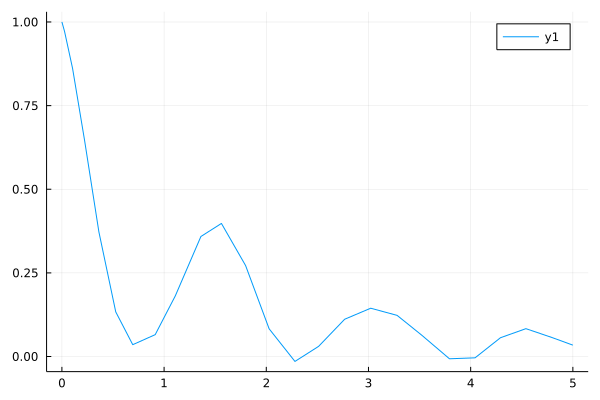

In [ ]:
plot(sol2.t,real.(sol2[σ2(2,2,2)]))